# Shapley, SVETA and SHAP values for a model system of low dimensionality.

In [2]:
from src.rbf_kernel import sveta_f_plus, sveta_f_minus
from src.rbf_kernel import inv_muiltinom_coeff
from src.rbf_kernel import tanimoto_similarity_sparse, tanimoto_similarity_dense

from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import os
import pandas as pd
import pickle
from scipy.stats import pearsonr
from scipy import sparse
from shap import KernelExplainer
from tqdm.auto import tqdm
import warnings

## Calculation method for standard Shapley values.

In [3]:
class ExactTanimotoShapley:
    """Calculates the Shapley value according to the Shapley formalism.

    """
    def __init__(self, ref_arr):
        self.ref_arr = ref_arr
    def sim(self, x):
        """Calculates the similarity of an instance x to the initialized vector `ref_arr`.
        This can be treated equivalent to a prediction of the similarity to ref_arr given x.
        Hence, we can explain the similarity with SHAP.
        """
        return tanimoto_similarity_dense(x, self.ref_arr.reshape((1, -1)))

    @staticmethod
    def _sim(x,y):
        intersection = x * y
        union = 1 - ((1- x)* (1- y))
        return np.sum(intersection) / np.sum(union)

    def shapley_values(self, x):
        ref = self.ref_arr
        assert x.shape == ref.shape
        shapley_vector = []
        for f_idx, (f_x, f_ref) in enumerate(zip(x, ref)):
            # Initializing the Shapley value as 0
            shapley_value = 0
            # Removing the assessed feature from the vectors
            remaining_f_x = np.delete(x, f_idx)
            remaining_f_ref = np.delete(ref, f_idx)

            # Iterating over all coalition sizes
            for coal_size in np.arange(0, x.shape[0]+1):
                if coal_size == 0: # if empty coalition:
                    if f_x == f_ref == 0:
                        # if the feature is absent in both instances, it does not affect the Tanimoto similarity.
                        # shapley value += 0 , or simply skip
                        continue
                    shapley_value += ((f_x*f_ref) -0) * inv_muiltinom_coeff(x.shape[0], coal_size)
                    continue
                feature_indices = np.arange(0, remaining_f_x.shape[0], dtype=int)

                #Creating all feature combinations as possible coalitions.
                for sel_features in combinations(feature_indices, r=coal_size):
                    sel_features = np.array(sel_features)
                    coal_x = remaining_f_x[sel_features]  # Coalition without assessed feature
                    coal_ref = remaining_f_ref[sel_features]  # Coalition without assessed feature
                    coal_x_fi = np.hstack([coal_x, [f_x]]) # Coalition with assessed feature
                    coal_ref_refi = np.hstack([coal_ref, [f_ref]])  # Coalition with assessed feature
                    if np.sum(coal_x_fi + coal_ref_refi) == 0:
                        # if the all features (including the assessed feature) are absent in both instances, they do not affect the Tanimoto similarity.
                        # shapley value += 0 , or simply skip
                        continue
                    if np.sum(coal_x + coal_ref) == 0: # if empty coalition (or coalition form only absent features), set subtracting term to 0
                        shapley_value += (self._sim(coal_x_fi, coal_ref_refi)-0) * inv_muiltinom_coeff(x.shape[0], coal_size)
                    else:
                        shapley_value += (self._sim(coal_x_fi, coal_ref_refi) - self._sim(coal_x, coal_ref)) * inv_muiltinom_coeff(x.shape[0], coal_size)
            shapley_vector.append(shapley_value)
        return np.array(shapley_vector)

## Generating random vectors.

In [4]:
# Initializing the random generator
r_gen = default_rng(202206014)

In [5]:
random_vectors = r_gen.integers(0,2,(20,15))
random_vectors_sparse = sparse.csr_matrix(random_vectors)
sim_mat = tanimoto_similarity_sparse(random_vectors_sparse, random_vectors_sparse)

# Generating SVs, SVETA values and SHAP values.
For all pairs SHAP SVETA and SVs are calculated and compared.

In [9]:
save_path = "./pickle_dumps/artificial_vector_sim.pkl"
if not os.path.isfile(save_path):
    explanation_df = []
    # Iterating over all pairs
    for i, vector_i in enumerate(random_vectors):
        exact_shapley_gen_i = ExactTanimotoShapley(vector_i)
        for j, vector_j in tqdm(enumerate(random_vectors), total=20):
            shapley_ij = exact_shapley_gen_i.shapley_values(vector_j)

            intersection_ij = vector_i * vector_j  # Vector where intersecting features are set to 1
            union_ij = 1 - (1-vector_i) * (1-vector_j)  # Vector where features of the union are set to 1
            diff_ij = union_ij - intersection_ij  # Vector where features from the symmetric difference are set to 1
            sveta_value_f_plus_ij = sveta_f_plus(sum(intersection_ij), sum(diff_ij))
            sveta_value_f_minus_ij = sveta_f_minus(sum(intersection_ij), sum(diff_ij))
            sveta_values_ij = intersection_ij * sveta_value_f_plus_ij  + diff_ij * sveta_value_f_minus_ij

            # Mask to get the 18 other vectors which are not i or j as background.
            mask_background_sample = np.ones(20, dtype=bool)
            mask_background_sample[i] = False
            mask_background_sample[j] = False
            with warnings.catch_warnings():
                # ignore all caught warnings
                warnings.filterwarnings("ignore")
                explainer_vec_i = KernelExplainer(exact_shapley_gen_i.sim, random_vectors[mask_background_sample])
                shap_ij = explainer_vec_i.shap_values(vector_j)

            explanation_df.append({"instance a": i,
                                   "instance b": j,
                                   "Shapley": shapley_ij,
                                   "SVETA": sveta_values_ij,
                                   "SHAP": shap_ij,
                                   "SHAP_expected_value": explainer_vec_i.expected_value[0],
                                   })
            
        break
    explanation_df = pd.DataFrame(explanation_df)
    # with open(save_path, "wb") as outfile:
    #     pickle.dump(explanation_df, outfile)
else:
    with open(save_path, "rb") as infile:
        explanation_df = pickle.load(infile)

  0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
corr_df = []
for i, row in explanation_df.iterrows():
    if row["instance a"] == row["instance b"]:
        continue
    shapley_exact = row["Shapley"]
    sveta_value = row["SVETA"]
    # Check if all values are closer than 10**-10 to shapley values.
    assert all(np.isclose(shapley_exact, sveta_value, 0, 1e-10))
    shap = row["SHAP"][0]
    
    corr, p = pearsonr(shap, shapley_exact)
    corr_df.append({"a": row["instance a"], "b": row["instance b"], "corrleation": corr})
corr_df = pd.DataFrame(corr_df)
corr_df["pearsons_r_fisher"] = np.arctanh(corr_df.corrleation)

In [16]:
SV = explanation_df.loc[19]["Shapley"]
SVeta = explanation_df.loc[19]["SVETA"]

SV == SVeta

print(SV)
print(SVeta)

[ 0.          0.20108422  0.         -0.09181261 -0.09181261 -0.09181261
  0.20108422 -0.09181261  0.20108422  0.         -0.09181261  0.
 -0.09181261  0.20108422  0.20108422]
[ 0.          0.20108422  0.         -0.09181261 -0.09181261 -0.09181261
  0.20108422 -0.09181261  0.20108422  0.         -0.09181261  0.
 -0.09181261  0.20108422  0.20108422]


In [12]:
explanation_df

,instance a,instance b,Shapley,SVETA,SHAP,SHAP_expected_value
0,0,0,"[0.0, 0.125, 0.0, 0.125, 0.0, 0.125, 0.125, 0....","[0.0, 0.125, 0.0, 0.125, 0.0, 0.125, 0.125, 0....","[[0.025021453985250394, 0.0621710433565021, 0....",0.404957
1,0,1,"[0.0, 0.21080064716424668, 0.0, -0.06373365691...","[0.0, 0.21080064716428348, 0.0, -0.06373365691...","[[0.011984548201769783, 0.053635652794551986, ...",0.408936
2,0,2,"[-0.06373365691547594, -0.06373365691547594, -...","[-0.06373365691547511, -0.06373365691547511, -...","[[-0.022159931237118846, -0.038162319577264084...",0.408936
3,0,3,"[0.0, 0.16077437519744564, -0.0978265146534485...","[0.0, 0.1607743751974522, -0.09782651465343777...","[[0.014714621034786917, 0.051464956926397805, ...",0.397540
4,0,4,"[-0.027950432758128335, -0.027950432758128335,...","[-0.02795043275812507, -0.02795043275812507, -...","[[-0.01576558333765512, -0.036699699855116494,...",0.418908
5,0,5,"[0.0, 0.250030864197499, 0.0, 0.25003086419749...","[0.0, 0.2500308641975309, 0.0, 0.2500308641975...","[[0.012524434836514381, 0.058747125572303216, ...",0.410788
6,0,6,"[-0.07345008526826582, -0.07345008526826582, -...","[-0.07345008526826709, -0.07345008526826709, -...","[[-0.024256671255699507, -0.03988947188178404,...",0.407253
7,0,7,"[0.0, 0.18573192239858355, -0.128597883597882,...","[0.0, 0.185731922398589, -0.1285978835978836, ...","[[0.01758242118428833, 0.05876990384117938, -0...",0.394121
8,0,8,"[-0.12853764921947142, 0.16435917617736195, -0...","[-0.1285376492194674, 0.16435917617735799, -0....","[[-0.033036117339338145, 0.056040612592561684,...",0.392101
9,0,9,"[0.0, -0.06429894179893791, -0.064298941798937...","[0.0, -0.0642989417989418, -0.0642989417989418...","[[0.01258981566256893, -0.041824111382980124, ...",0.410788


In [ ]:
assert corr_df.query("corrleation.isna()").shape[0] == 0

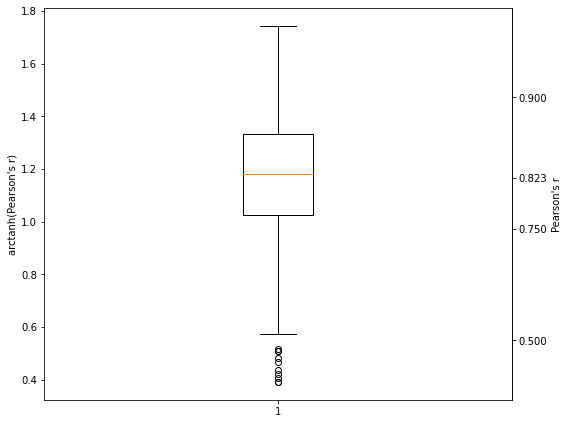

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(corr_df.pearsons_r_fisher)
ax.set_ylabel("arctanh(Pearson's r)")
secax = ax.secondary_yaxis('right', functions=(np.tanh, np.arctanh))
secax.set_ylabel("Pearson's r")
secax.set_yticks([-0.5, 0, 0.5, 0.75, 0.823, 0.9, 0.95, 0.99]);
ax.set_xlabel("")
plt.tight_layout()

In [ ]:
np.tanh(corr_df["pearsons_r_fisher"].mean())

0.8236403539669996

In [ ]:
np.tanh(corr_df["pearsons_r_fisher"].std())

0.25006282724875234